In [1]:
from fusions.diffusion import Diffusion
from fusions.cfm import CFM
from lsbi.model import LinearMixtureModel
import numpy as np
import anesthetic as ns

# Setup a problem with lsbi

Five dimensional parameter space

In [2]:
dims = 5
data_dims = dims
np.random.seed(12)

mixtures = 5
A = np.random.randn(mixtures, data_dims, dims)
Model = LinearMixtureModel(
    # M=A,
    M=np.stack([np.eye(dims), -np.eye(dims)]),
    mu=np.zeros(dims),
    sigma=np.eye(dims),
    m=np.zeros(data_dims),
    C=np.eye(data_dims)*0.1,
)

data = Model.evidence().rvs()



draw the posterior in orange and prior in blue

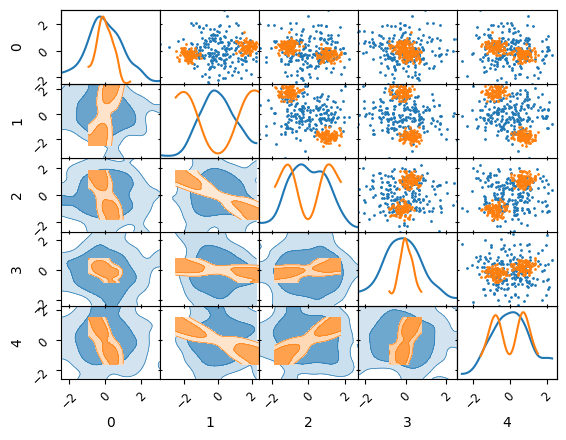

In [3]:
size = 200
P = Model.posterior(data).rvs(size)
theta=Model.prior().rvs(size)
a = ns.MCMCSamples(theta).plot_2d(np.arange(dims))
a= ns.MCMCSamples(P).plot_2d(a)

# Training a diffusion model

Sample from the posterior as training data. Train a Continuous Flow Matching objective

In [4]:
training_data = Model.posterior(data).rvs(size*10)
# diffusion = Diffusion(prior = Model.prior())
diffusion = CFM(prior = Model.prior())

In [5]:
diffusion.train(training_data,n_epochs=1000)

100%|██████████| 1000/1000 [00:02<00:00, 344.34it/s]


Now we can compare how well this trained flow approximates the target

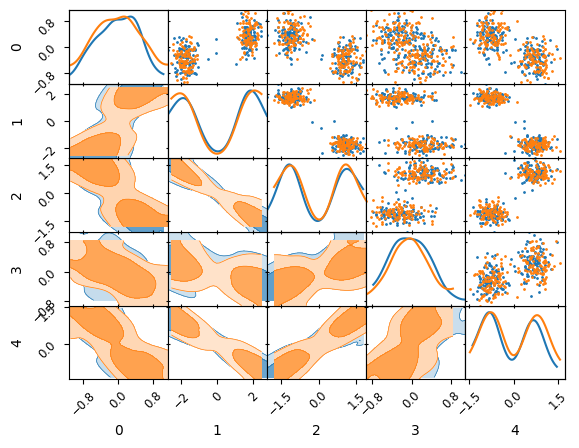

In [7]:
size = 200
P = Model.posterior(data).rvs(size)
theta=diffusion.rvs(size)
a = ns.MCMCSamples(theta).plot_2d(np.arange(dims))
a= ns.MCMCSamples(P).plot_2d(a)

# Trajectories in ODE
Of interest to is in how straight lines drawn in either the prior or a gaussian latent space are mapped to the target.

## As a function of "time"
The forward model that the CFM encodes is a neural ODE, we can track the evolution of this as afunction of the time parameter introduced in training

In [8]:
t=Model.prior().rvs(1000)
x, x_t =diffusion.predict(t, history=True)

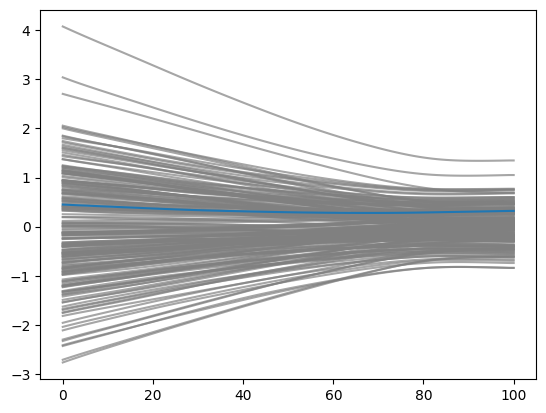

In [9]:
import matplotlib.pyplot as plt
f,a = plt.subplots()
param_idx=3
a.plot(x_t[:,:199,param_idx], color="grey", alpha=0.7);
a.plot(x_t[:,200,param_idx], color="C0")

## As a function of path

We can build a set of adjacent points that cuts through our 5d space in a straight line from either
* [-1,-1,-1,-1,-1] to [1,1,1,1,1] 

or

* [-1,0,0,0,0] to [1,1,1,1,1]

and then examine what it looks like after being diffused

In [18]:
line_x = np.linspace(-1,1,50)
line_y=np.zeros((line_x.shape[0], 4))
test_x=np.repeat(line_x[...,None], 5, axis=1)
# test_x=np.concatenate([np.atleast_2d(line_x),line_y.T]).T

In [19]:
target_x ,x_t = diffusion.predict(test_x, history=True)

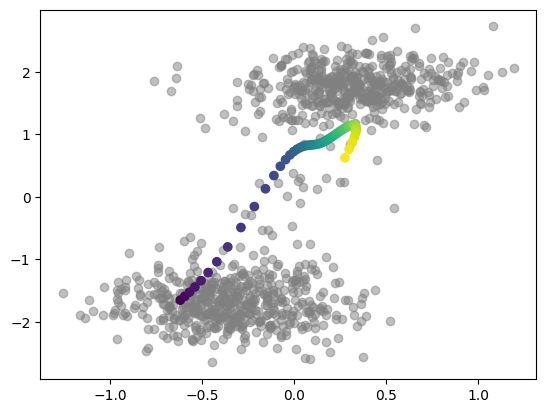

In [25]:
# plt.scatter(target_x[:,param_idx], target_x[:,param_idx+1], c= np.arange(len(line_x)))
param_idx = 0
plt.scatter(x[:,param_idx], x[:,param_idx+1], c="grey", alpha=0.5)
plt.scatter(target_x[:,param_idx], target_x[:,param_idx+1], c= np.arange(len(line_x)))
# plt.plot(x_t[:,:,param_idx], x_t[:,:,param_idx+1])
plt.savefig("slice_demo_sde.pdf")

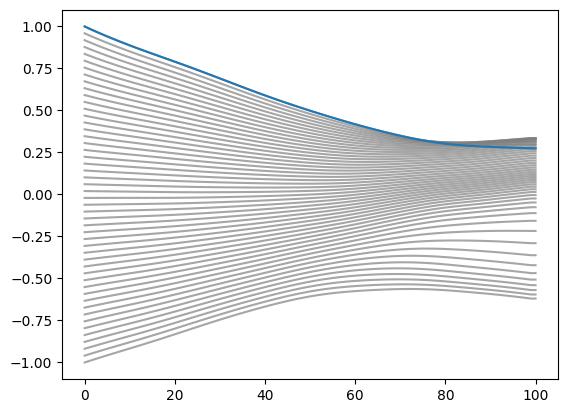

In [27]:
f,a = plt.subplots()
param_idx=0
a.plot(x_t[:,:,param_idx], color="grey", alpha=0.7);
a.plot(x_t[:,200,param_idx], color="C0")